# Image Classification using Intel Image Classification Dataset

## Introduction
In this assignment, we aim to develop a classifier to categorize images into six natural scene categories: buildings, forest, glacier, mountain, sea, and street. The dataset provided by [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) consists of approximately 25,000 images, each of size 150x150 pixels. These images are divided into training, testing, and prediction sets.

The primary objective of this project is to build a robust model that can accurately classify the images into their respective categories. The process involves several key steps:

        1. **Data Loading and Preprocessing:** 
        2. **Exploratory Data Analysis (EDA):**
        3. **Model Development:**
        4. **Model Training and Validation:**
        5. **Model Evaluation:**
        6. **Performance Assessment:**

### 1. Import Libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint ,  ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 2. Read Data


In [2]:
# Set paths
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Image size
img_size = (150, 150)

### 3. Exploratory Data Analysis (EDA)

1- **Visualize Sample Images:**
  - Display 5 sample images from each class to get an initial understanding of the dataset and the variety of images within each class.

2- **Analyze Class Distribution:**
  - Create a bar plot to show the distribution of images across the different classes. This will help identify any class imbalances in the dataset.

3- **Color Channel Analysis:**
  - Examine the color channels (RGB) of a sample image from each class. This step involves plotting the histograms for each color channel to understand the color distribution within the images.

4- **Visualize Average Image:**
  - Compute and visualize the average image for each class. This is achieved by averaging the pixel values of all images in a class to create a composite image that represents the average appearance of that class.

### 1. VISUALIZATION OF SOME IMAGES FFROM EACH CLASS

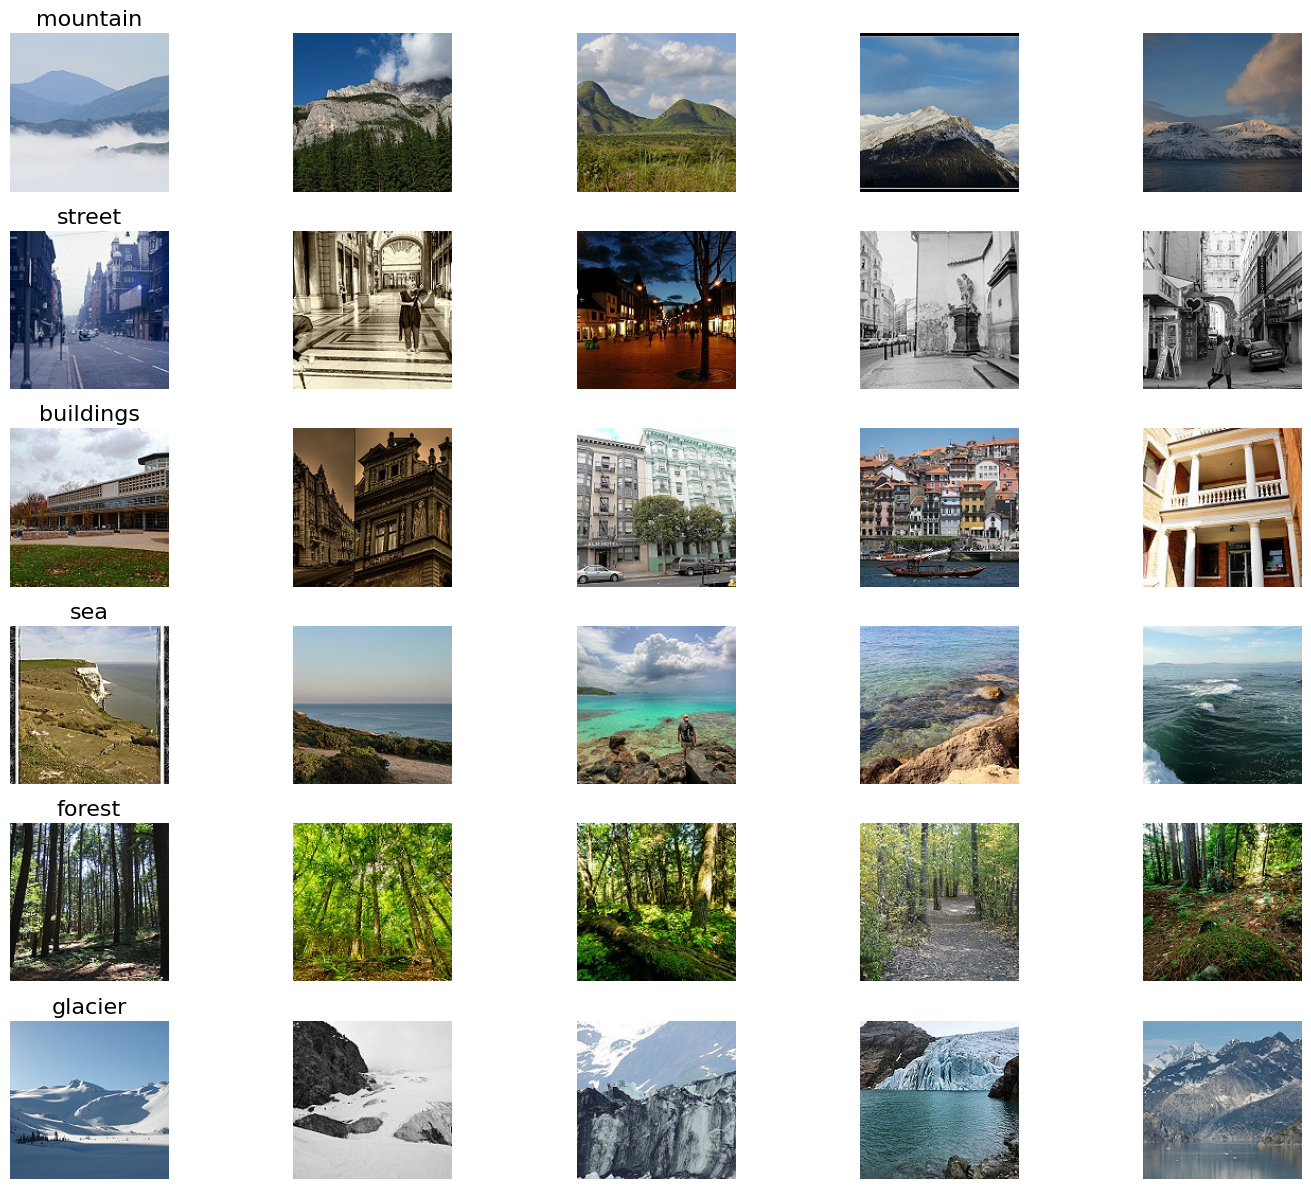

In [3]:
# Define the train directory path
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'

# Class names (assuming the directory names are the class labels)
class_names = os.listdir(train_dir)

# Number of classes
num_classes = len(class_names)

# Number of images to display per class
num_images_per_class = 5

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, num_classes * 2))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)[:num_images_per_class]  # Get first few images
    
    for j, image_file in enumerate(image_files):
        img_path = os.path.join(class_dir, image_file)
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img)
        img_array /= 255.0  # Normalize the image
        
        axes[i, j].imshow(img_array)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, size=16)

plt.tight_layout()
plt.show()

#### 2. DISTRIBUTION OF CLASSES

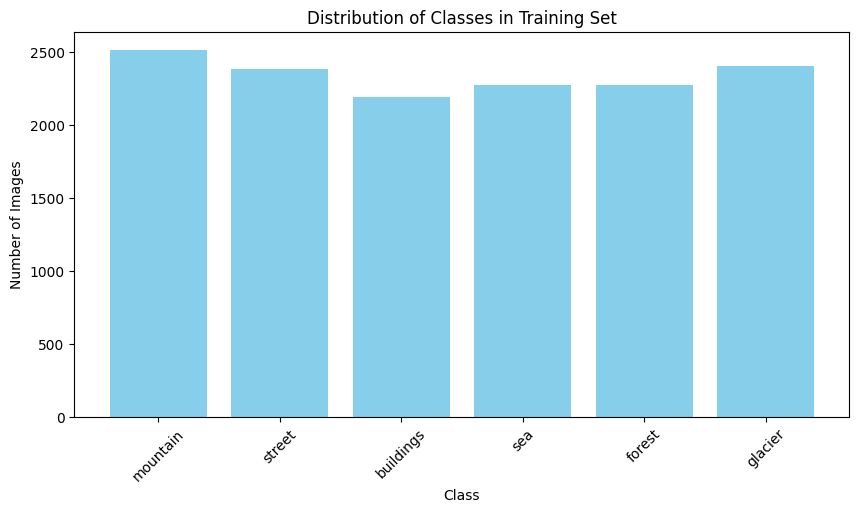

In [4]:
# Count the number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45)
plt.show()

#### Our Data is balanced and we dont need to deal with class imbalance

#### 3. COLOUR CHANNEL ANALYSIS

<Figure size 1200x600 with 0 Axes>

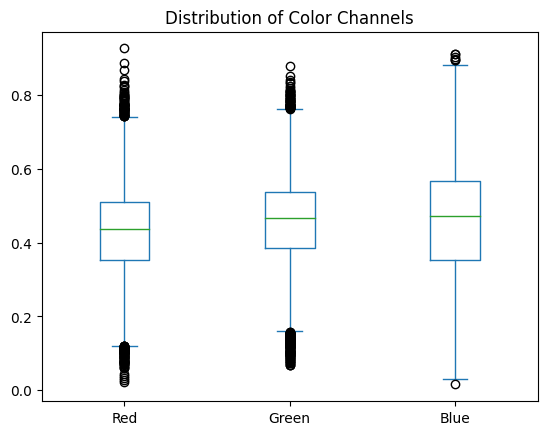

In [5]:
# Function to get color channel means
def get_color_means(directory):
    means = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpeg', 'jpg', 'png')):
                img_path = os.path.join(subdir, file)
                img = load_img(img_path, target_size=(150, 150))
                img_array = img_to_array(img) / 255.0
                means.append(img_array.mean(axis=(0, 1)))
    return np.array(means)

# Get color channel means for training dataset
color_means = get_color_means(train_dir)

# Convert to DataFrame for easy plotting
color_df = pd.DataFrame(color_means, columns=['Red', 'Green', 'Blue'])

# Plot color channel distributions
plt.figure(figsize=(12, 6))
color_df.plot(kind='box', title='Distribution of Color Channels')
plt.show()

#### 4. VISUALIZE AVERAGE IMAGE

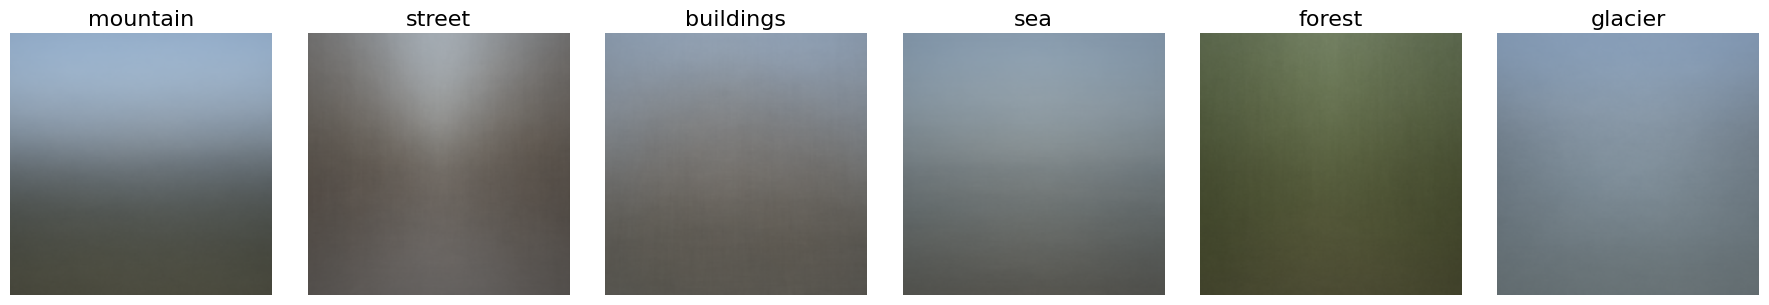

In [6]:
# Function to compute average image for each class
def compute_average_image(directory, target_size=(150, 150)):
    avg_images = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        image_sum = np.zeros((target_size[0], target_size[1], 3))
        count = 0
        for file in os.listdir(class_dir):
            if file.endswith(('jpeg', 'jpg', 'png')):
                img_path = os.path.join(class_dir, file)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img) / 255.0
                image_sum += img_array
                count += 1
        avg_images[class_name] = image_sum / count
    return avg_images

# Compute average images for each class
avg_images = compute_average_image(train_dir)

# Plot average images
fig, axes = plt.subplots(1, num_classes, figsize=(18, 3))
for i, (class_name, avg_img) in enumerate(avg_images.items()):
    axes[i].imshow(avg_img)
    axes[i].axis('off')
    axes[i].set_title(class_name, size=16)

plt.tight_layout()
plt.show()

------------

### 4. Data Augmentation and Normalization:


- **Training Data Augmentation and Normalization:**
  - We use `ImageDataGenerator` from Keras to perform real-time data augmentation and normalization on the training data.
  - The pixel values of the images are rescaled from [0, 255] to [0, 1] using `rescale=1./255`.
  - Random shear transformations are applied with `shear_range=0.2` to change the shape of the objects in the images slightly.
  - Random zoom transformations are applied with `zoom_range=0.2` to randomly zoom in on the images.
  - Random horizontal flipping of images is allowed with `horizontal_flip=True` to increase the diversity of the training data.
  - To ensure that a portion of the data is used for validation, we set `validation_split=0.2`, reserving 20% of the data for validation purposes.

- **Validation Data Normalization:**
  - For the validation set, we only perform rescaling to normalize the pixel values from [0, 255] to [0, 1] using `rescale=1./255`.
  - No other augmentations are applied to the validation data to ensure it remains unchanged, providing a consistent measure of the model's performance.

In [7]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

# No augmentation for validation
test_datagen = ImageDataGenerator(rescale=1./255)


### 5. Data Generators

- **Training Data Generator:**
  - We use the `ImageDataGenerator` from Keras to create a data generator for the training set.
  - The training data generator is created using `train_datagen.flow_from_directory` which loads images from the specified directory (`train_dir`).
  - The images are resized to the target size specified by `img_size`.
  - We set the `batch_size` to 32, which means 32 images will be processed in each batch.
  - The `class_mode` is set to 'categorical' to perform multi-class classification.
  - We use `subset='training'` to specify that this generator is for the training data, utilizing the 80% of the data reserved for training due to the `validation_split=0.2` setting earlier.

- **Validation Data Generator:**
  - Similar to the training data generator, the validation data generator is created using `train_datagen.flow_from_directory`.
  - The images are resized to the target size specified by `img_size`.
  - The `batch_size` is also set to 32.
  - The `class_mode` is set to 'categorical'.
  - We use `subset='validation'` to specify that this generator is for the validation data, utilizing the 20% of the data reserved for validation.

- **Test Data Generator:**
  - The test data generator is created using `test_datagen.flow_from_directory` which loads images from the specified directory (`test_dir`).
  - The images are resized to the target size specified by `img_size`.
  - The `batch_size` is set to 32.
  - The `class_mode` is set to 'categorical'.
  - We set `shuffle=False` to ensure that the order of the images is preserved, which is important for evaluating the model accurately.

In [8]:

# Create data generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         target_size=img_size,
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         subset='validation')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=img_size,
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


----

## Model Archiitecture
### Building and Compiling the VGG16-based Model

- **Define Input Shape:**
  - We define the input shape of the images as (150, 150, 3), which corresponds to 150x150 pixels and 3 color channels (RGB).

- **Load the VGG16 Model:**
  - We load the pre-trained VGG16 model with weights from 'imagenet'. We exclude the top (fully connected) layers by setting `include_top=False`. The input tensor is defined by `inputs` which matches the specified input shape.

- **Freeze the Base Model Initially:**
  - To retain the pre-trained weights, we freeze the base model layers by setting `layer.trainable = False` for each layer in the base model.

- **Unfreeze the Top Layers:**
  - We selectively unfreeze the last 4 convolutional blocks of the base model to allow fine-tuning. This is done by setting `layer.trainable = True` for these layers.

- **Add Custom Layers:**
  - We add custom fully connected layers on top of the base model:
    - `Flatten()`: Flattens the output from the base model.
    - `Dense(512, activation='relu')`: Fully connected layer with 512 units and ReLU activation.
    - `Dropout(0.5)`: Dropout layer with a dropout rate of 50% to prevent overfitting.
    - `Dense(256, activation='relu')`: Fully connected layer with 256 units and ReLU activation.
    - `Dropout(0.5)`: Dropout layer with a dropout rate of 50%.
    - `Dense(6, activation='softmax')`: Output layer with 6 units (one for each class) and softmax activation for multi-class classification.

- **Create the Full Model:**
  - We create the full model by defining the inputs as `base_model.input` and the outputs as `predictions`.

- **Compile the Model:**
  - We compile the model using the Adam optimizer with a lower learning rate (`learning_rate=1e-5`) for fine-tuning.
  - The loss function is set to 'categorical_crossentropy' for multi-class classification.
  - We include 'accuracy' as a metric to monitor during training.

- **Display the Model Summary:**

In [9]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

# Define input shape
input_shape = (150, 150, 3)
inputs = Input(shape=input_shape)

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top layers (last 4 convolutional blocks)
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 19,042,374 (72.64 MB)

 Trainable params: 11,407,110 (43.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

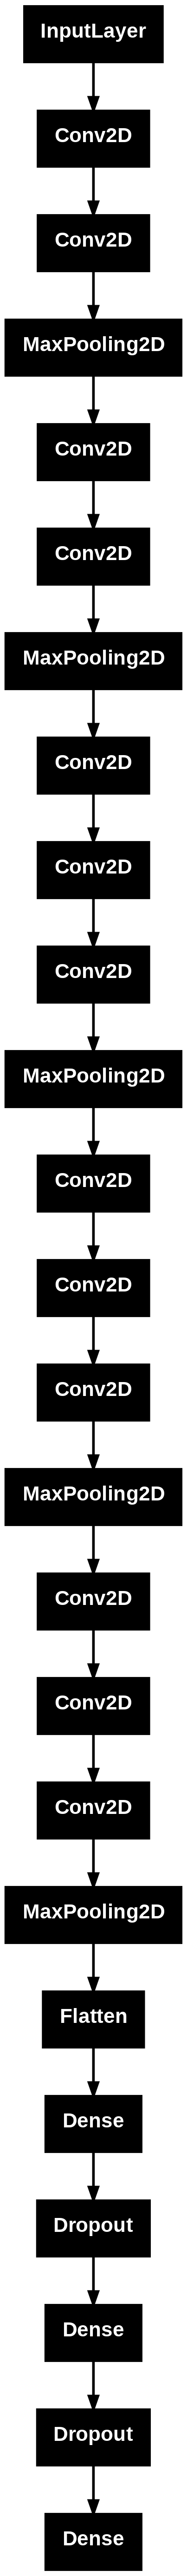

In [10]:

from keras.utils import plot_model
plot_model(model)

In [11]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)

# Train the model with the defined callbacks
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.3489 - loss: 1.6260
Epoch 1: val_loss improved from inf to 0.51679, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 247ms/step - accuracy: 0.3498 - loss: 1.6237 - val_accuracy: 0.8242 - val_loss: 0.5168 - learning_rate: 1.0000e-05
Epoch 2/20
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7612 - loss: 0.6513
Epoch 2: val_loss improved from 0.51679 to 0.37356, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - accuracy: 0.7613 - loss: 0.6510 - val_accuracy: 0.8709 - val_loss: 0.3736 - learning_rate: 1.0000e-05
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8339 - loss: 0.4814
Epoch 3: val_loss improved from 0.37356 to 0.33648, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - accuracy: 0.8339 - loss: 0.4814 - val_accuracy: 0.8837 - val_loss: 0.3365 - learning_rate: 1.0000e-05
Epoch 4/20
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/ste

### 6. Model Evaluation

### Plot Training History

- **Accuracy Plot:**
- **Loss Plot:**

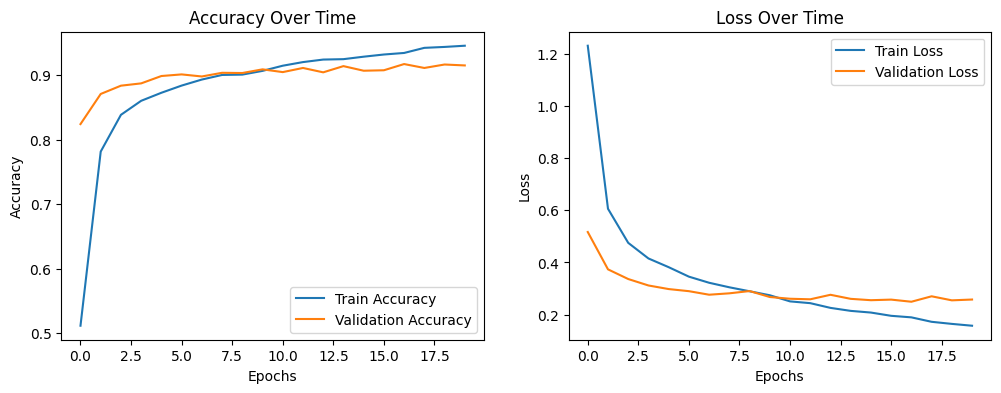

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')

plt.show()

###  **Evaluating the Model:**
  - We begin by printing a message "Evaluating the model..." to indicate the start of the evaluation process.

- **Print the Evaluation Results:**
  - The following results are printed in a concise format:
    - **Training Loss:** Measures how well the model fits the training data. A lower value indicates a better fit.
    - **Training Accuracy:** The percentage of correctly classified instances in the training data. Higher accuracy indicates better performance.
    - **Test Loss:** Measures how well the model generalizes to unseen data. A lower value indicates better generalization.
    - **Test Accuracy:** The percentage of correctly classified instances in the test data. Higher accuracy indicates better performance.



In [13]:
# Step 8: Evaluate the Model
print("Evaluating the model...")

# Evaluate on the training data
train_loss, train_acc = model.evaluate(train_generator, verbose=0)

# Evaluate on the test (validation) data
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

# Print the evaluation results in a concise format
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Evaluating the model...
Training Loss: 0.1255, Training Accuracy: 95.73%
Test Loss: 0.2407, Test Accuracy: 91.73%


### Classification Report

In [14]:
# Predict the test set and print additional details
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(labels, predicted_classes, target_names=class_labels))

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.93      0.92       437
      forest       0.98      0.99      0.98       474
     glacier       0.88      0.86      0.87       553
    mountain       0.88      0.85      0.87       525
         sea       0.93      0.97      0.95       510
      street       0.94      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



### Classification Report Description and Insights

#### Description:
The classification report provides detailed metrics for evaluating the performance of the model on the test dataset. It includes the following metrics for each class (buildings, forest, glacier, mountain, sea, street):

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates a low false negative rate.
- **F1-Score:** The weighted average of precision and recall. It considers both false positives and false negatives.
- **Support:** The number of actual instances in the class.

Additionally, the report provides the overall accuracy, macro average, and weighted average for all classes.

#### Insights:
- **Overall Accuracy:** The model achieved an accuracy of 92% on the test dataset, indicating that it performs well in correctly classifying images across all classes.
- **Class Performance:**
  - **Forest:** Achieved the highest precision (0.98) and recall (0.99), indicating excellent performance in identifying forest images.
  - **Sea:** Also performed very well with a high precision (0.93) and recall (0.97).
  - **Buildings, Glacier, Mountain, and Street:** These classes also showed strong performance with precision and recall values generally above 0.85, though slightly lower compared to Forest and Sea.
- **Balanced Performance:** The macro and weighted averages of precision, recall, and F1-score are all 0.92, suggesting balanced performance across all classes without significant bias towards any particular class.

Overall, the model demonstrates strong and balanced classification performance across all categories in the test dataset.

### confusion Matrix

<Figure size 1000x800 with 0 Axes>

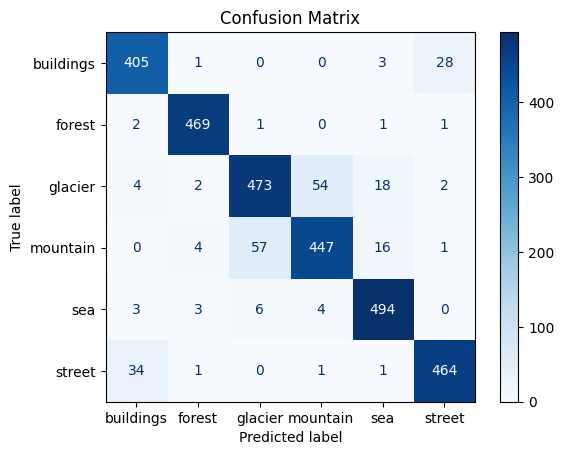

In [19]:
# Get the true labels
true_labels = test_generator.classes
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Insights

#### Strong Performance:
- High correct predictions for most classes (diagonal values are dominant).
#### Notable Misclassifications:
- **Glacier and Mountain:** Higher confusion between these classes (e.g., 54 glacier misclassified as mountain and 57 mountain misclassified as glacier).
- **Street:** Occasionally misclassified as "Buildings" (34 instances).
#### Minimal Errors:
- **Forest and Sea:** Very few misclassifications, indicating excellent performance for these classes.
### Focus Areas:
- **Improve Differentiation:** Focus on improving the model's ability to distinguish between "Glacier" and "Mountain."
- **Address Misclassification:** Work on reducing the instances of "Street" being misclassified as "Buildings."


In [20]:
# Binarize the labels for multi-class ROC
labels_binarized = label_binarize(labels, classes=range(len(class_labels)))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_binarized.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

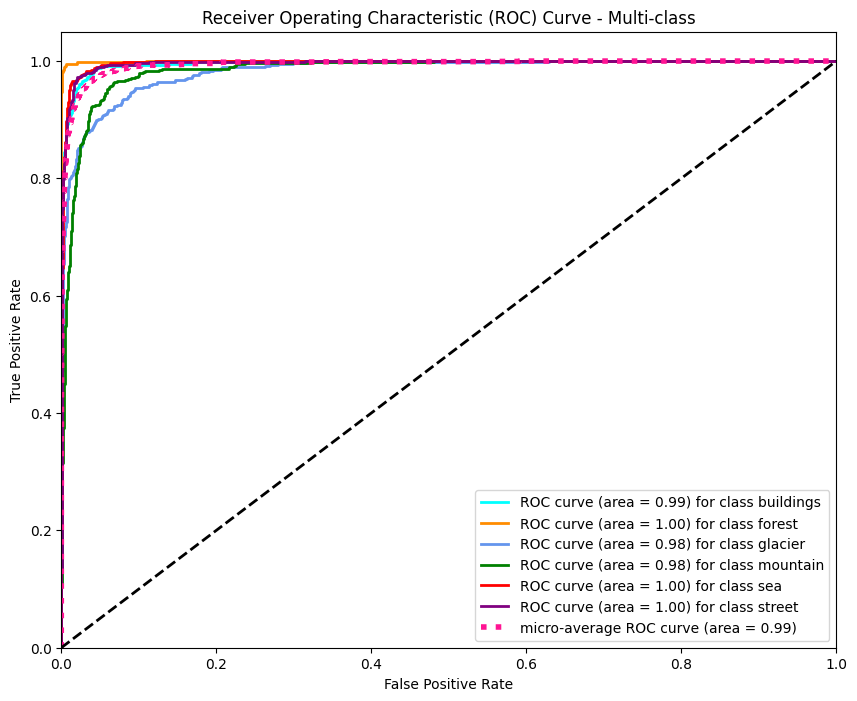

In [21]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {class_labels[i]}')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()

### ROC Curve Insights for Classification Model

#### High AUC Values:
- All classes have excellent AUC values, ranging from 0.98 to 1.00, indicating the classifier's strong ability to distinguish between each class.

#### Perfect Classification:
- **Forest, Sea, Street:** These classes have perfect AUC values of 1.00, suggesting the model is performing flawlessly for these classes.

#### Slightly Lower AUC Values:
- **Glacier, Mountain:** These classes have AUC values of 0.98, which are still excellent but may indicate minor room for improvement.

#### Micro-average ROC Curve:
- The micro-average ROC curve has an AUC of 0.99, reflecting the model's overall classification performance across all classes. It suggests that the model is highly effective on average.

### Recommendations:
- **Evaluate Confusion Matrices:** Focus on evaluating confusion matrices or class-specific errors for "glacier" and "mountain" to identify specific cases where the model struggles.
- **Check for Overfitting:** For classes with AUC = 1.00, ensure that the model's training data doesn't suffer from overfitting.


----------

### Conclusion and Recommendations:

The developed model demonstrates effective classification of natural scene images, achieving high accuracy and reliability. However, there is room for improvement in distinguishing between similar categories like Glacier and Mountain. To further enhance performance:

- **Data Augmentation:** Increase variability in the dataset to improve generalization.
- **Class-Specific Optimization:** Address inter-class overlaps using weighted loss functions or feature engineering.
- **Hyperparameter Tuning:** Experiment with model architecture, learning rate, and batch size for optimal results.

This assignment illustrates a comprehensive workflow for image classification using deep learning techniques and provides insights into the model's effectiveness for real-world applications.

-------------